# Tutorial for QA of Directional Field during Tractography

This tutorial is designed to illustrate the QA code used to generate the figure for the maximal directional field during Tractography. 

m2g uses dipy's CSA and CSD Models. 

## The following tutorial will generate the QA figures for both a CSA and CSD Model:

We will walk through the main usage of the qa_tensor.py file and provide an alternative visualization for the 3-D vector field of the data.

In [1]:
#general imports
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

#dipy imports
from dipy.reconst.shm import CsaOdfModel
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, recursive_response

from dipy.data import get_sphere
from dipy.direction import peaks_from_model, ProbabilisticDirectionGetter
from dipy.segment.mask import median_otsu
from dipy.core.gradients import gradient_table

from dipy.data import default_sphere

from dipy.viz import window, actor, has_fury, colormap

from m2g.stats import qa_tensor

## Data Inputs: 

- Change location of output_folder after running m2g on desired dataset to your output folder

In [2]:
#change this location
output_folder = '/Users/wilsontang/Desktop/m2g_outputs/sub-0025842/sub-0025842/ses-1/'

#standard outputs
bvals_loc = "dwi/preproc/bval.bval"
bvecs_loc = "dwi/preproc/bvec.bvec"
preproc_data_loc = "dwi/preproc/eddy_corrected_data_reor_RAS_nores.nii.gz"
wm_mask_loc = "anat/registered/t1w_wm_in_dwi.nii.gz"

# bval and bvec data to build the gradient table
bvals = np.loadtxt(f"{output_folder}{bvals_loc}")
bvecs = np.loadtxt(f"{output_folder}{bvecs_loc}")

# load nifti image as numpy
preproc_im = nib.load(f"{output_folder}{preproc_data_loc}").get_fdata()

# load white matter masks 
wm_mask = nib.load(f"{output_folder}{wm_mask_loc}").get_data().astype("bool")

## CSA Model 

### Generating the model 
Replicates appropriate steps in m2g's tractography to build a CSA model and extract the peak values

In [3]:
#build gradient table
gtab = gradient_table(bvals, bvecs)

#running model
csa_model = CsaOdfModel(gtab, sh_order=6)

#selecting sphere
sphere_mod = get_sphere('repulsion724')

#extracting peaks
csa_peaks = peaks_from_model(model=csa_model,
                             data= preproc_im,
                             sphere=sphere_mod,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             npeaks = 5,
                             normalize_peaks=True,
                             mask = wm_mask
                            )

These peaks are passed into our qa function to make the figure that is saved within your output folder under ./qa/tensor/

An example figure is generated from the model above:

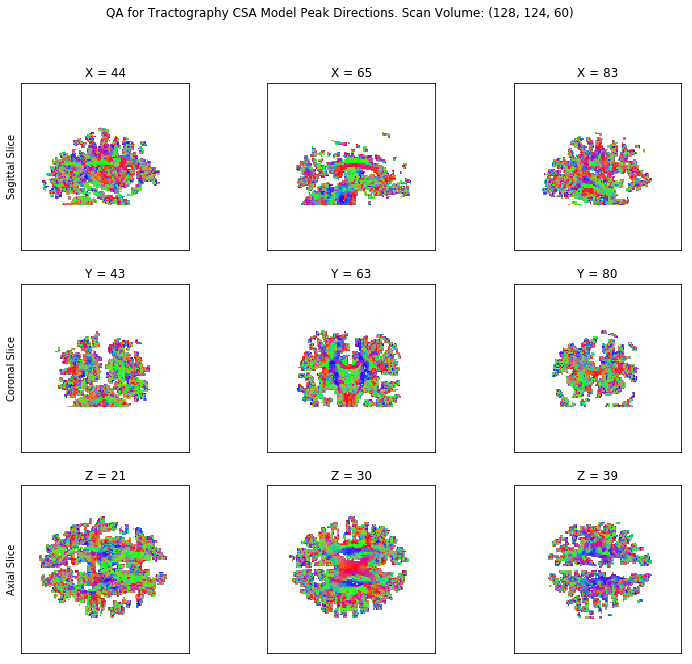

In [4]:
peak_dirs_csa = csa_peaks.peak_dirs
peak_values_csa = csa_peaks.peak_values

qa_tensor.create_qa_figure(peak_dirs_csa,peak_values_csa,'Tractography_Model_Peak_Directions','csa')

## CSD Model

### Generating the model 
Replicates appropriate steps in m2g's tractography to build a CSD model and extract the peak values

In [ ]:
#build gradient table
gtab = gradient_table(bvals, bvecs)

try: 
    print("Attempting to use spherical harmonic basis first...")
    csd_model = ConstrainedSphericalDeconvModel(self.gtab, None, sh_order=6)

except: 
    #build response
    response = recursive_response(
                    gtab,
                    preproc_im,
                    mask =wm_mask,
                    sh_order=6,
                    peak_thr=0.01,
                    init_fa=0.08,
                    init_trace=0.0021,
                    iter=8,
                    convergence=0.001,
                    parallel=False,
                )

    #build csd model
    csd_model = ConstrainedSphericalDeconvModel(gtab,response,sh_order=6)

#extracting peaks
csd_peaks = peaks_from_model(model=csd_model,
                             data= preproc_im,
                             sphere=sphere_mod,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             npeaks = 5,
                             normalize_peaks=True,
                             mask = wm_mask
                            )


Attempting to use spherical harmonic basis first...


These peaks are passed into our qa function to make the figure that is saved within your output folder under ./qa/tensor/

An example figure is generated from the model above:

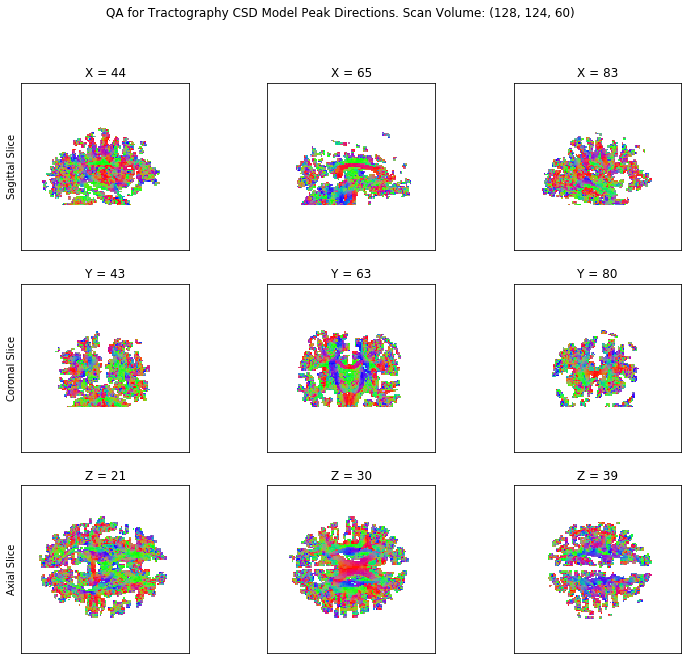

In [ ]:
peak_dirs_csd = csd_peaks.peak_dirs
peak_values_csd = csd_peaks.peak_values

qa_tensor.create_qa_figure(peak_dirs_csd,peak_values_csd,'Tractography_Model_Peak_Directions','CSD')

## 3-d Visualization 

There is also a 3-d visualization of the model peaks using fury, which will open a separate viewer to visualize the 3-d brain with vectors representing each brain peak at each voxel. You can use the mouse to zoom in and rotate this 3-d volume.

In [ ]:
qa_tensor.plot_directions(peak_dirs_csa,peak_values_csa,0,0,size=(300,300))